In [2]:
import tensorflow as tf

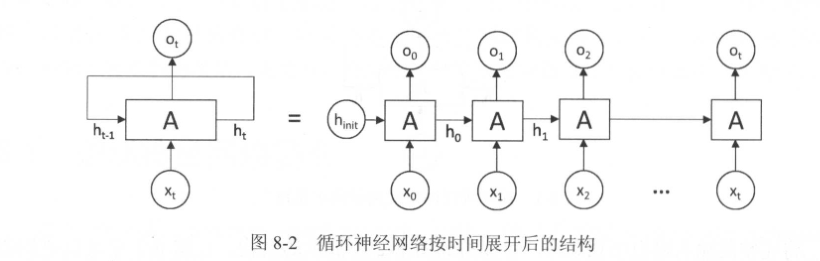

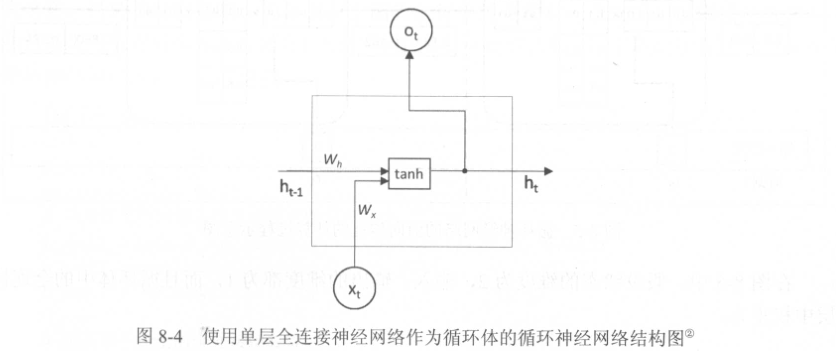

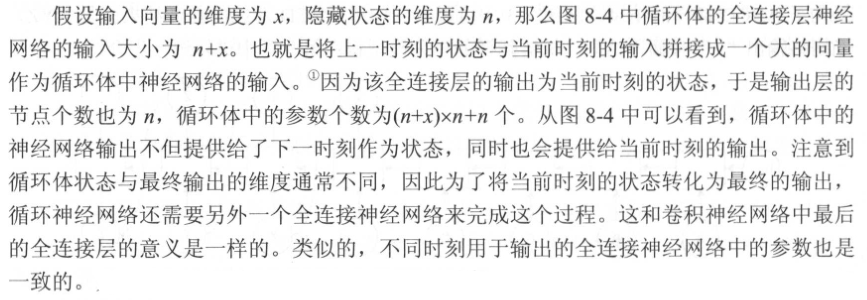

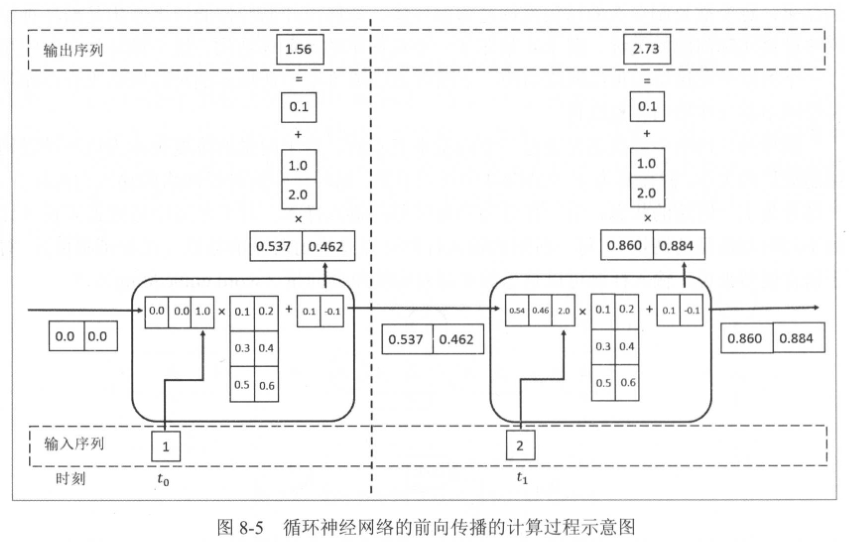

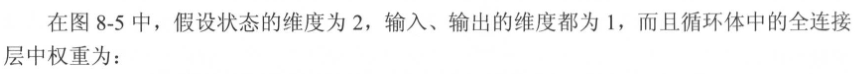

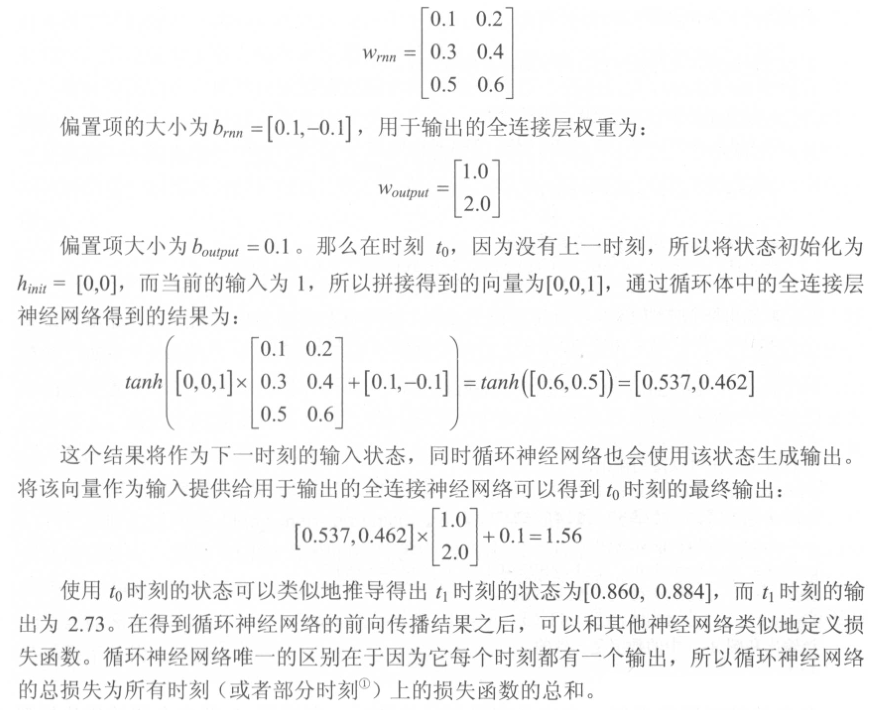

In [3]:
# 循环神经网络前向传播过程
import numpy as np

X = [1, 2]
state = [0.0, 0.0]

# 分开定义不同输入部分的权重以方便操作
w_cell_state = np.asarray([[0.1, 0.2], [0.3, 0.4]])
w_cell_input = np.asarray([0.5, 0.6])
b_cell = np.asarray([0.1, -0.1])

# 定义用于输出的全连接层参数
w_output = np.asarray([[1.0], [2.0]])
b_output = 0.1

# 按照实际顺序执行循环神经网络的前向传播过程
for i in range(len(X)):
    # 计算循环体中的全连接层神经网络
    before_activation = np.dot(state, w_cell_state) + X[i] * w_cell_input + b_cell
    state = np.tanh(before_activation)
    
    # 根据当前时刻状态计算最终输出
    final_output = np.dot(state, w_output) + b_output
    
    # 输出每个时刻的信息
    print('before activation: ', before_activation)
    print('state: ', state)
    print('output: ', final_output)
    print('')

before activation:  [ 0.6  0.5]
state:  [ 0.53704957  0.46211716]
output:  [ 1.56128388]

before activation:  [ 1.2923401   1.39225678]
state:  [ 0.85973818  0.88366641]
output:  [ 2.72707101]



# 长短时记忆网络（LSTM）结构

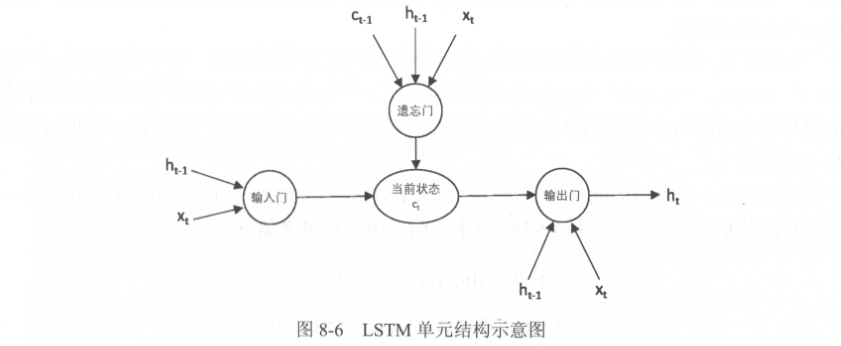

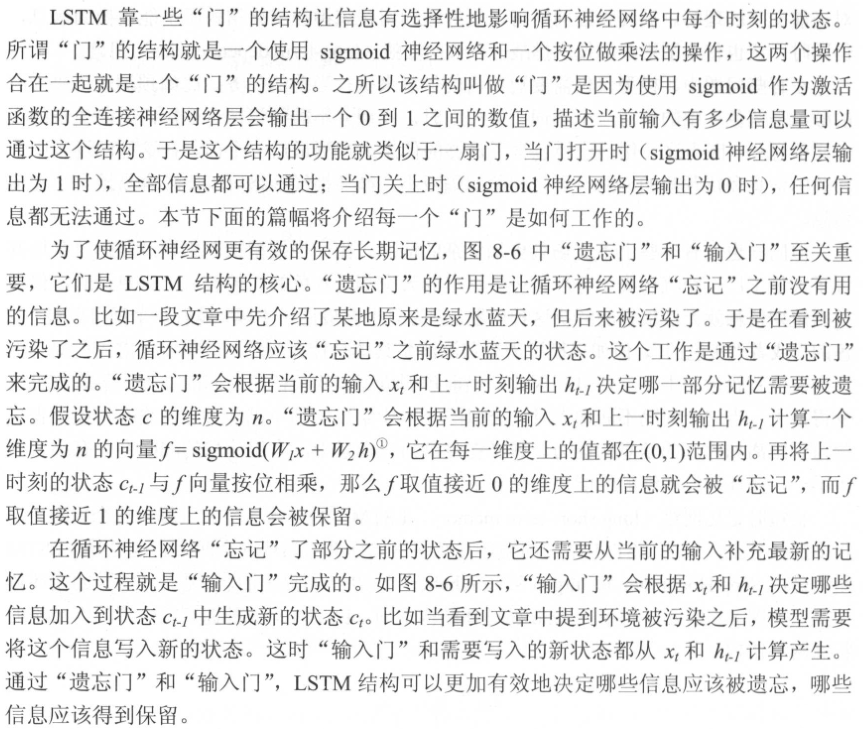

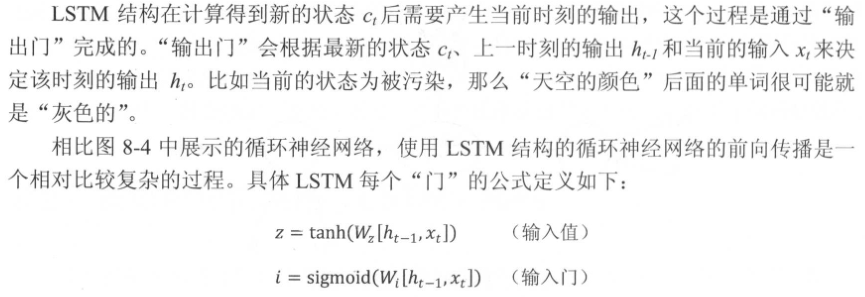

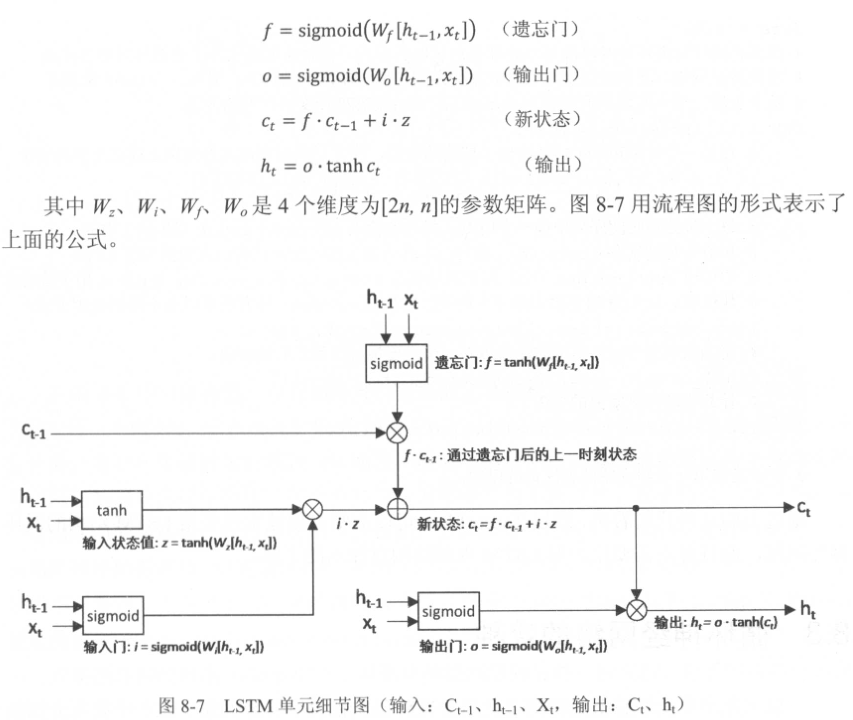

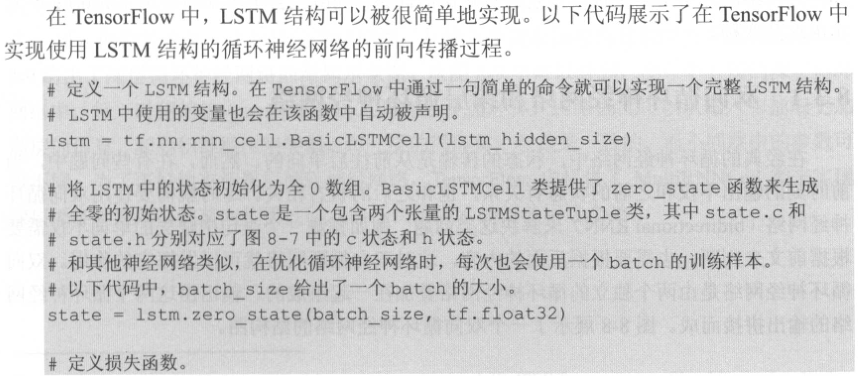

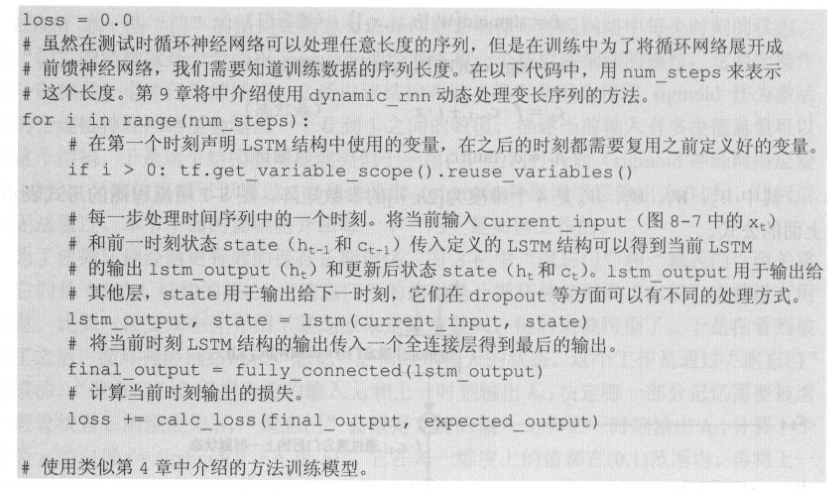

# 循环神经网络的变种
## 双向循环网络和深层循环神经网络

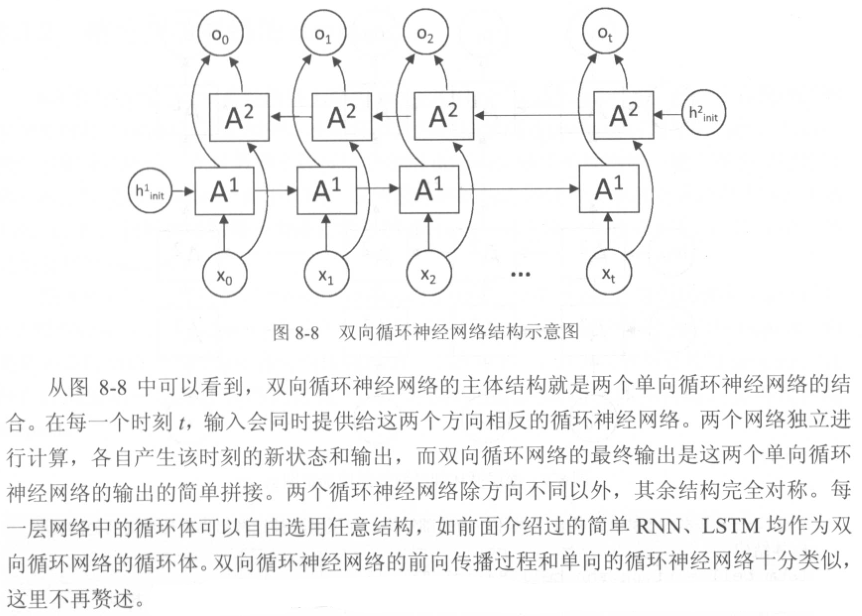

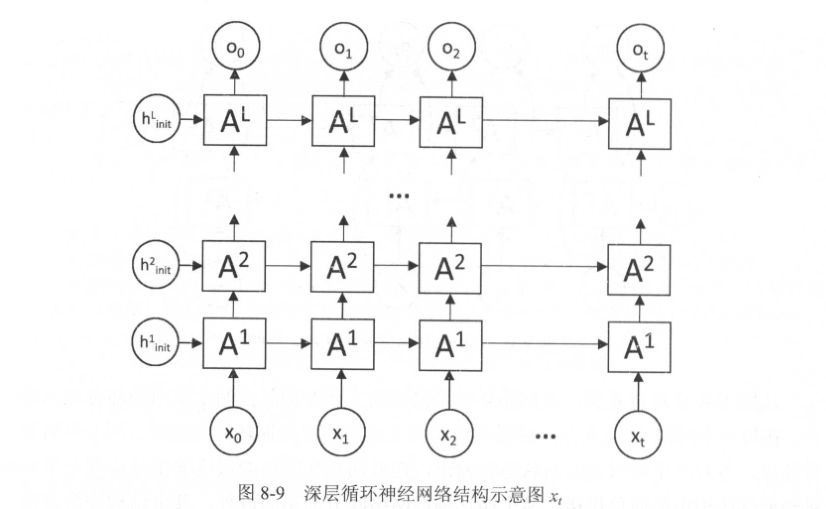

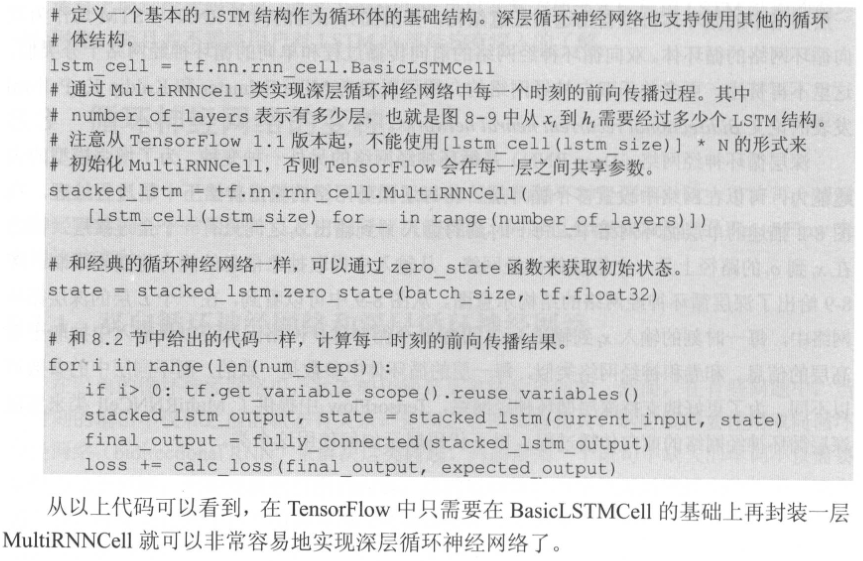

## 循环神经网络的dropout

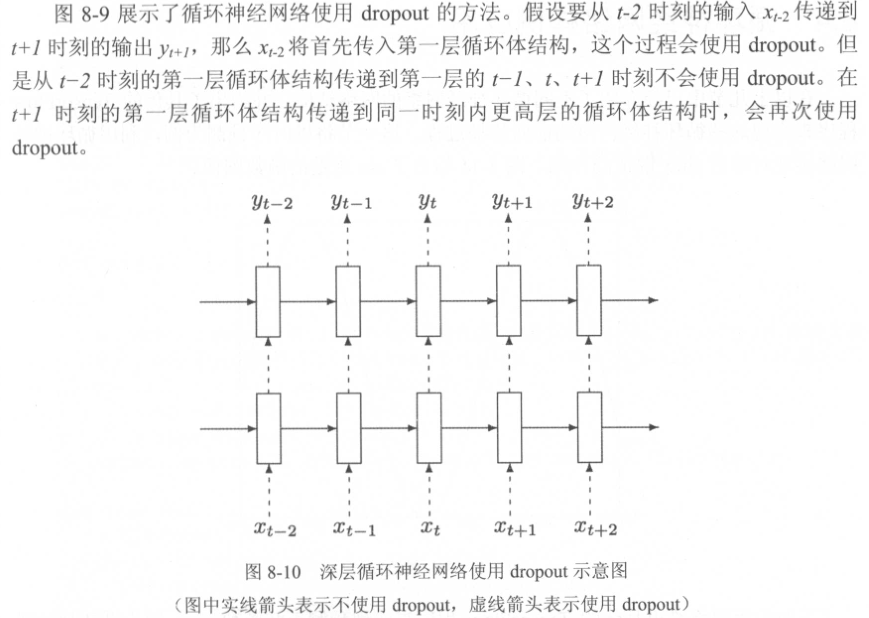

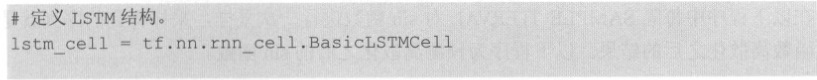

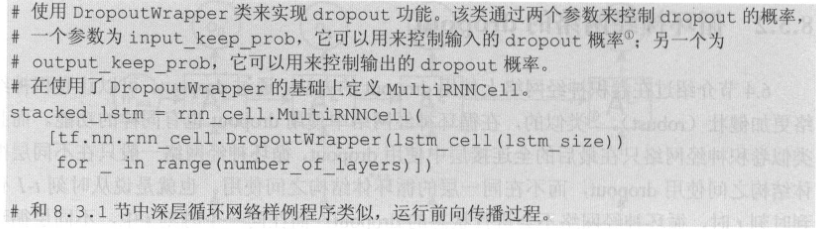

# 循环神经网络样例应用（有误）

In [1]:
import numpy as np
import tensorflow as tf

# 加载matplotlib工具包，对预测的sin函数进行绘图
import matplotlib as mpl
mpl.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline

HIDDEN_SIZE = 30
NUM_LAYERS = 2

TIMESTEPS = 10  # 循环神经网络的训练序列长度
TRAINING_STEPS = 10000 
BATCH_SIZE = 32

TRAINING_EXAMPLES = 10000  #  训练数据个数
TESTING_EXAMPLES = 1000
SAMPLE_GAP = 0.01  # 采样间隔

def generate_data(seq):
    X = []
    y = []
    # 序列的第 i 项和后面的TIMESTEPS-1项在一起作为输入
    # 第 i + TIMESTEPS项作为输出
    # 即用sin函数前面的TIMESTEPS个点的信息，预测第 i + TIMESTEPS个点的函数值
    for i in range(len(seq) - TIMESTEPS):
        X.append([seq[i: i + TIMESTEPS]])
        y.append([seq[i + TIMESTEPS]])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

def lstm_model(X, y, is_training):
    # 使用多层的LSTM结构
    cell = tf.nn.rnn_cell.MultiRNNCell([tf.nn.rnn_cell.BasicLSTMCell(HIDDEN_SIZE)
                                       for _ in range(NUM_LAYERS)])
    
    # 使用Tensorflow接口将多层的LSTM结构连接成RNN网络并计算其前向传播结果
    outputs, _ = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
    # outputs是顶层LSTM在每一步的输出结果，维度是[batch_size, time, HIDDEN_SIZE]
    # 在本问题中只关注最后一个时刻的输出结果
    output = outputs[:, -1, :]
    
    # 对LSTM网络的输出再做一层全连接层并计算损失，默认平方差损失函数
    predictions = tf.contrib.layers.fully_connected(output, 1, activation_fn=None)
    
    # 只在训练时计算损失函数和优化步骤。测试时直接返回预测结果
    if not is_training:
        return predictions, None, None
    
    # 计算损失函数
    loss = tf.losses.mean_squared_error(labels=y, predictions=predictions)
    
    # 创建模型优化器并得到优化步骤
    train_op = tf.contrib.layers.optimize_loss(loss,
                                              tf.train.get_global_step(),
                                              optimizer = 'Adagrad',
                                              learning_rate = 0.1)
    return predictions, loss, train_op

def train(sess, train_X, train_y):
    # 将训练数据以数据集的方式提供给计算图
    ds = tf.data.Dataset.from_tensor_slices((train_X, train_y))
    ds = ds.repeat().shuffle(1000).batch(BATCH_SIZE)
    X, y = ds.make_one_shot_iterator().get_next()
    
    # 调用模型，得到预测结果、损失函数和训练操作
    with tf.variable_scope('model'):
        predictions, loss, train_op = lstm_model(X, y, True)
        
    # 初始化变量
    sess.run(tf.global_variables_initializer())
    for i in range(TRAINING_STEPS):
        _, l = sess.run([train_op, loss])
        if i % 1000 == 0:
            print('train step: ' + str(i) + ", loss: " + str(l))
            
def run_eval(sess, test_X, test_y):
    # 将测试数据以数据集的方式提供给计算图
    ds = tf.data.Dataset.from_tensor_slices((test_X, test_y))
    ds = ds.batch(1)
    X, y = ds.make_one_shot_iterator().get_next()
    
    # 调用模型得到计算结果。这里不需要输入真实的y值
    with tf.variable_scope('model', reuse=True):
        prediction, _, _ = lstm_model(X, [0.0], False)
        
        # 将预测结果存入一个数组。
        predictions = []
        labels = []
        for i in range(TESTING_EXAMPLES):
            p, l = sess.run([prediction, y])
            predictions.append(p)
            labels.append(l)

        # 计算rmse作为评价指标。
        predictions = np.array(predictions).squeeze()
        labels = np.array(labels).squeeze()
        rmse = np.sqrt(((predictions - labels) ** 2).mean(axis=0))
        print("Root Mean Square Error is: %f" % rmse)

        #对预测的sin函数曲线进行绘图。
        plt.figure()
        plt.plot(predictions, label='predictions')
        plt.plot(labels, label='real_sin')
        plt.legend()
        plt.show()

/opt/Anaconda/envs/tensorflow1.5/lib/python3.5/site-packages/scipy/__init__.py:144: UserWarning: Numpy 1.13.3 or above is required for this version of scipy (detected version 1.13.1)
  UserWarning)


train step: 0, loss: 36.5601
train step: 1000, loss: 362.776
train step: 2000, loss: 78.2621
train step: 3000, loss: 104.71
train step: 4000, loss: 94.1135
train step: 5000, loss: 1708.15
train step: 6000, loss: 241.156
train step: 7000, loss: 79.6763
train step: 8000, loss: 86.4637
train step: 9000, loss: 78.5454
Root Mean Square Error is: 82.384521


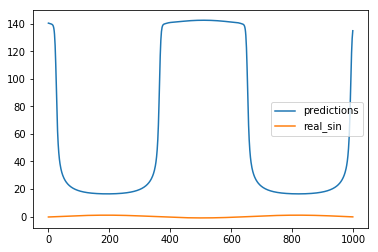

In [2]:
# 用正弦函数生成训练和测试数据集合
# numpy.linspace函数可以创建一个等差序列的数字，常用有3个参数
# 第1个参数表示起始值，第2个参数表示终止值，第3个参数表示数列的长度
test_start = (TRAINING_EXAMPLES + TIMESTEPS) * SAMPLE_GAP
test_end = test_start + (TESTING_EXAMPLES + TIMESTEPS) * SAMPLE_GAP
train_X, train_y = generate_data(np.linspace(0,
                                            test_start,
                                            TRAINING_EXAMPLES + TIMESTEPS,
                                            dtype=np.float32))
test_X, test_y = generate_data(np.sin(np.linspace(test_start,
                                                 test_end,
                                                 TESTING_EXAMPLES + TIMESTEPS,
                                                 dtype=np.float32)))

# print('训练数据：', train_X)
# print('训练标签：', train_y)

# print('测试数据：', test_X)
# print('测试标签：', test_y)

with tf.Session() as sess:
    # 训练模型
    train(sess, train_X, train_y)
    # 使用训练好的模型对测试数据进行预测
    run_eval(sess, test_X, test_y)